# Building a review classifier

In this homework, we will complete the following task:
1. use your parser to collect data of many movie reviews from rotten tomatoes
2. use this data to build a classifier
3. evaluate the classifier
4. perform some exploratory data analysis on your data (optional)

## 1. Collect Data

In this part, I will get all critics' reviews of the weekly top 15 box office movies (Nov. 8 - Nov. 10) from Rotten Tomatoes. 

1. I collect the movies' name and links from the weekend box office ranking chart (https://rottentomatoes.com/browse/box-office/).
2. I slightly modify the last parser in the last homework to get all reviews of a movie. With the links obtained from the step 1, I can retrieve all reviews of these 15 movies.


In [1]:
# Import needed modules
import requests
import re
import time
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# get html for a single page
def get_html(url): 
    my_header = {'User Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'}
    src = False
    
    # try 3 times to get the page
    for i in range(3): 
        try:
            response = requests.get(url, headers = my_header)
            src = response.content
            break
        except:
            time.sleep(2)
    return src

### Parse weekend top box office chart

In the chart, information of each movie is between `<tr>` `</tr>` tags. Name and link is between `<a>` `</a>` tags.

![](https://github.com/hujiayin/WebAnalytics/blob/master/Classifier%20for%20reviews/boxOfficeHTML.jpg?raw=true)

In [188]:
# Get html of box office chart website
movie_website = 'https://rottentomatoes.com/browse/box-office/'
movie_list_html = get_html(movie_website)
movie_list_soup = BeautifulSoup(movie_list_html.decode('ascii', 'ignore'), 'lxml')
movie_list = movie_list_soup.findAll('tr', {'itemprop':"itemListElement"})

In [189]:
# Get the top 50 movies' names and links
movie_name = []
movie_link = []
for movie in movie_list:
    name = movie.find('a', {'class': "", 'data-pageheader':""}).contents[0]
    link = movie.find('a', {'class': "", 'data-pageheader':""}).attrs['href']
    movie_name.append(name)
    movie_link.append(link)

In [747]:
# Store the top 15 movies' name and links
movie_dict = dict(zip(movie_name[:15], movie_link[:15]))

In [748]:
movie_dict

{'Midway': '/m/midway_2019/',
 'Doctor Sleep': '/m/doctor_sleep/',
 'Playing with Fire': '/m/playing_with_fire_2019/',
 'Last Christmas': '/m/last_christmas_2019/',
 'Terminator: Dark Fate': '/m/terminator_dark_fate/',
 'Joker': '/m/joker_2019/',
 'Maleficent: Mistress of Evil': '/m/maleficent_mistress_of_evil/',
 'Harriet': '/m/harriet/',
 'Zombieland: Double Tap': '/m/zombieland_double_tap/',
 'The Addams Family': '/m/the_addams_family_2019/',
 'Jojo Rabbit': '/m/jojo_rabbit/',
 'Countdown': '/m/countdown_2019/',
 'Parasite (Gisaengchung)': '/m/parasite_2019/',
 'Motherless Brooklyn': '/m/motherless_brooklyn/',
 'Black and Blue': '/m/black_and_blue_2019/'}

### Retrive reviews

After getting the links of these 15 movies, we parse the html of the review pages to retrieve reviews. The process is basically similar as the last homework, except for I get the total number of review pages to make sure retrieve all reviews. 

(Last homework reference: https://github.com/hujiayin/WebAnalytics/blob/master/Web%20Content/crawling_movie_reviews.ipynb)

In [445]:
# Create a dataframe to save all reviews
review_df = pd.DataFrame(columns=['Movie', 'Critic', 'Rating', 'Source', 'Review', 'Date'])

In [446]:
def get_reviews(movie_name, review_url):
    
    # Get the total number of pages to make sure retrieve all reviews
    review_html = get_html(review_url)
    page_info_find = BeautifulSoup(review_html.decode('ascii', 'ignore'), 'lxml').find('span', \
                                                                                  {'class':'pageInfo'})
    page_num = int(page_info_find.contents[0].split(' ')[-1]) if page_info_find else int(1)
    
    # Create a temporary dataframe to save the revies of a single movie
    df_temp = pd.DataFrame(columns=['Movie', 'Critic', 'Rating', 'Source', 'Review', 'Date'])
    
    # Parse html in every page
    for i in range(page_num):
        url = 'https://rottentomatoes.com' + movie_dict[movie_name] + 'reviews?page=' + str(i+1)

        html = get_html(url)

        if not html:
            print('Failed get ' + movie + ' page ' + str(i+1))

        else:
            soup = BeautifulSoup(html.decode('ascii', 'ignore'), 'lxml')
            review_info = soup.findAll('div', {'class':'row review_table_row'})

            for review in review_info:

                '''
                If the tag for any field is not found in html or the content is empty, 
                set default value NA for the field.
                '''

                # Find critic's name
                name_find = review.find('a', {'href': re.compile('critic')})
                critic = name_find.text.strip() if name_find else 'NA'
                critic = critic if critic != '' else 'NA'

                # Find rating
                rating_find = review.find('div', {'class': re.compile('review_icon')})
                rating = rating_find.attrs['class'][-1].strip() if rating_find else 'NA'
                rating = rating if rating != '' else 'NA'

                # Find source
                source_find = review.find('em', {'class': re.compile('critic-publication')})
                source = source_find.text.strip() if source_find else 'NA'
                source = source if source != '' else 'NA'

                # Find review content
                review_text_find = review.find('div', {'class': 'the_review'})
                review_text = review_text_find.text.strip() if review_text_find else 'NA'
                review_text = review_text if review_text != '' else 'NA'

                # Find review date
                date_find = review.find('div', {'class': re.compile('review-date')})
                date = date_find.text.strip() if date_find else 'NA'
                date = date if date != '' else 'NA'
                
                review_dict = {'Movie': movie_name, 'Critic': critic, 'Rating': rating, 'Source': source,
                               'Review': review_text, 'Date': date}
                
                df_temp = df_temp.append(review_dict, ignore_index=True)
                
    return df_temp


In [447]:
# Retrieve all revie
for movie in movie_dict:
    url = 'https://rottentomatoes.com' + movie_dict[movie] + 'reviews'
    df_temp = get_reviews(movie, url)
    review_df = review_df.append(df_temp, ignore_index=True)

Finally, I obtain 3006 reviews of all 15 movies. And for the convinice in the future, I save the dataframe into a local file.

In [450]:
review_df.to_csv('movie_review.csv', index=False)

## 2. Basic Understanding of the Dataset

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [469]:
# read data
review_df = pd.read_csv('movie_review.csv')

### Prepare data - Check missing value and  Transform target data

In [470]:
# Check missing data
print('Review missing data: ', sum(review_df['Review']=='NA'), '\n',
      'Rating missing data: ', sum(review_df['Rating']=='NA'))


Review missing data:  0 
 Rating missing data:  0


There's no missing data for both reviews and ratings.

Since the target data which will be predict is categorical data, I need to transform the strings into numerical form.

In [471]:
review_df['Rating'].unique()

array(['rotten', 'fresh'], dtype=object)

Rating column only contains 'rotten' and 'fresh', we try to transform Rating to 0/1 binary data.

In [472]:
# Transform Rating to binary data
review_df['target'] = review_df['Rating'].replace(['rotten', 'fresh'], [0, 1])

### Overview of target data

In [473]:
rating_table = review_df.groupby(['Movie']).apply(lambda df: pd.Series({'fresh_count': df.target.sum(), 'rotten_count': df.target.count() - df.target.sum()}))
rating_table['fresh_proportion'] = rating_table['fresh_count'] / (rating_table['fresh_count'] + rating_table['rotten_count'])
rating_table['rotten_proportion'] = rating_table['rotten_count'] / (rating_table['fresh_count'] + rating_table['rotten_count'])
rating_table.sort_values(by=['fresh_proportion'], ascending=False, inplace=True)
rating_table

,fresh_count,rotten_count,fresh_proportion,rotten_proportion
Movie,,,,
Parasite (Gisaengchung),285,3,0.989583,0.010417
Jojo Rabbit,215,56,0.793358,0.206642
Doctor Sleep,211,65,0.764493,0.235507
Harriet,120,45,0.727273,0.272727
Terminator: Dark Fate,214,85,0.715719,0.284281
Zombieland: Double Tap,148,67,0.688372,0.311628
Joker,352,160,0.687500,0.312500
Motherless Brooklyn,89,56,0.613793,0.386207
Black and Blue,44,42,0.511628,0.488372


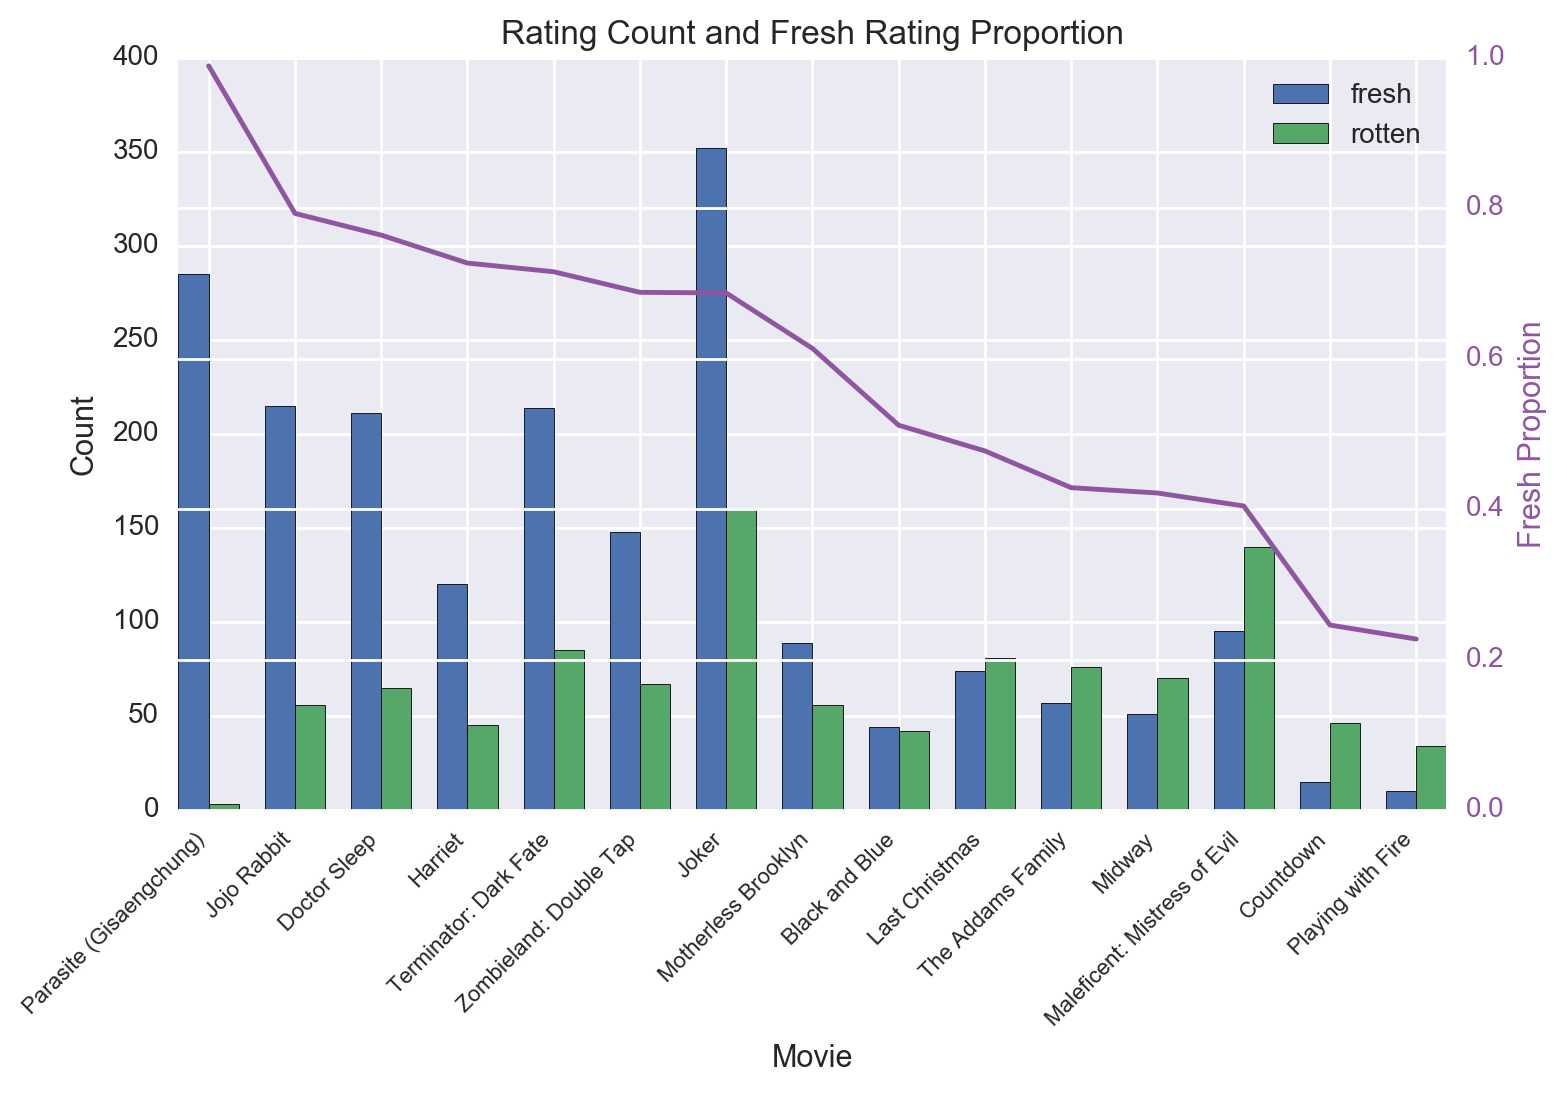

In [474]:
fig, ax1 = plt.subplots(dpi=200)

ax1.set_xlabel('Movie')
ax1.set_ylabel('Count')

x = np.arange(len(rating_table))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax1.bar(x - width/2, rating_table['fresh_count'], width, label='fresh')
rects2 = ax1.bar(x + width/2, rating_table['rotten_count'], width, label='rotten')
ax1.legend()
ax1.set_xticklabels(x, rotation=45, horizontalalignment='right', size=8)

color = '#9055A2'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Fresh Proportion', color=color)  # we already handled the x-label with ax1
ax2.plot(list(rating_table.index), rating_table['fresh_proportion'], color=color)
ax2.set_ylim([0, 1])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Rating Count and Fresh Rating Proportion')
plt.savefig('Rating Count and Fresh Rating Proportion.jpg', dpi=400)
plt.show()

In [475]:
dist_table = pd.DataFrame({'Count': [rating_table['fresh_count'].sum(), rating_table['rotten_count'].sum()], 
                           'Proportion': [rating_table['fresh_count'].sum() / (rating_table['fresh_count'].sum() + rating_table['rotten_count'].sum()),
                                          rating_table['rotten_count'].sum() / (rating_table['fresh_count'].sum() + rating_table['rotten_count'].sum())]}, 
                         index = ['Fresh', 'Rotten'])
dist_table

,Count,Proportion
Fresh,1980,0.658683
Rotten,1026,0.341317


In [ ]:
review_df['Review_text_lemma'] = review_df['Review_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))